In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', None)
pd.set_option('future.no_silent_downcasting', True)
sns.set()

df = pd.read_csv('data_part_2.csv')

print(df.shape)
df.head()

(1009, 18)


,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,final_price,time_of_day,sold
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0,night,1
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN,NaN,morning,0
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN,NaN,night,0
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN,NaN,evening,0
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN,NaN,day,0


# Set Proper Data Types

In [2]:
dtype_mapping = {
    'user_id': 'int64', 
    'region': 'object', 
    'device': 'object', 
    'channel': 'object', 
    'session_start': 'datetime64[ns]', 
    'session_end': 'datetime64[ns]', 
    'sessiondurationsec': 'float64', 
    'session_date': 'datetime64[ns]', 
    'month': 'int64', 
    'day': 'int64', 
    'hour_of_day': 'int64', 
    'order_dt': 'datetime64[ns]', 
    'revenue': 'float64', 
    'payment_type': 'object', 
    'promo_code': 'float64'
}

df = df.astype(dtype_mapping)

# Custom Functions

In [22]:
import os

MONTH_NAMES = {
    5: 'Май', 6: 'Июнь', 7: 'Июль',
    8: 'Август', 9: 'Сентябрь', 10: 'Октябрь'
}

def calculate_average_metric(df, metric_col, groupby_cols=None, top_n=None, ascending=False, visualize=False, 
                             title=None, fig_size=(10, 6), rotation=0, category_order=None, save=False,
                             metric_type='aov', chronological=False):
    if groupby_cols is None:
        return df[metric_col].mean()

    if metric_col == 'revenue':
        if metric_type not in ['aov', 'arpu']:
            raise ValueError("metric_type must be either 'aov' or 'arpu'")
        if metric_type == 'arpu':
            df = df.copy()
            df['revenue'] = df['revenue'].fillna(0)

    if isinstance(groupby_cols, list) and 'month' in groupby_cols:
        df = df.copy()
        df['month'] = df['month'].map(MONTH_NAMES)
        if chronological:
            category_order = list(MONTH_NAMES.values())
    
    result = df.groupby(groupby_cols)[metric_col].mean().round(2)
    
    if isinstance(groupby_cols, list) and len(groupby_cols) > 1:
        if chronological and 'month' in groupby_cols:
            result = result.reindex(category_order, level=groupby_cols.index('month'))
        elif category_order is not None:
            result = result.reindex(category_order, level=0)
        else:
            single_group_means = df.groupby(groupby_cols[0])[metric_col].mean()
            sorted_order = single_group_means.sort_values(ascending=ascending).index
            if top_n:
                sorted_order = sorted_order[:top_n]
            result = result.reindex(sorted_order, level=0)
    else:
        if chronological and 'month' in groupby_cols:
            result = result.reindex(category_order, level=groupby_cols.index('month'))
        elif category_order is not None:
            result = result.reindex(category_order)
        else:
            result = result.sort_values(ascending=ascending)
            if top_n:
                result = result.head(top_n)
    
    if visualize:
        fig, ax = plt.subplots(figsize=fig_size)
        
        if isinstance(groupby_cols, list) and len(groupby_cols) > 1:
            pivot_data = result.unstack()
            pivot_data.plot(kind='bar', ax=ax)
            for container in ax.containers:
                labels = [f'{v:.2f}' if v > 0 else '' for v in container.datavalues]
                ax.bar_label(container, labels=labels, padding=3)
            plt.legend(title=groupby_cols[1], bbox_to_anchor=(1, 1), loc='upper left')
            ymax = pivot_data.max().max()
        else:
            result.plot(kind='bar', ax=ax)
            for i, v in enumerate(result):
                ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')
            ymax = result.max()
            
        ax.set_ylim(0, ymax * 1.1)
        metric_label = metric_type.upper() if metric_col == 'revenue' else metric_col
        plt.title(title or f'Average {metric_label} by {groupby_cols}')
        plt.xlabel(groupby_cols if isinstance(groupby_cols, str) else groupby_cols[0])
        plt.ylabel(f'Average {metric_col}')
        plt.xticks(rotation=rotation)
        plt.tight_layout()
        
        if save:
            folder_path = './Graphs 3'
            os.makedirs(folder_path, exist_ok=True)

            metric_name = f"{metric_type.upper()}_{metric_col}" if metric_col == 'revenue' else metric_col
    
            if isinstance(groupby_cols, list):
                filename = f"{metric_name}_by_{'_'.join(groupby_cols)}.png"
            else:
                filename = f"{metric_name}_by_{groupby_cols}.png"

            plt.savefig(
                fname=os.path.join(folder_path, filename),
                format='png',
                bbox_inches='tight',
                dpi=300
            )
            
        plt.show()
        
    return result

def calculate_user_activity(df, group_cols):
    return df.groupby(group_cols)['user_id'].nunique()

def calculate_mau(df, group_cols=['month', 'channel'], visualize=False, fig_size=(15, 7), 
                 title=None, rotation=0, save=False):
    if 'month' not in group_cols:
        raise ValueError("'month' must be in group_cols")
        
    df_calc = df.copy()
    
    df_calc['month'] = df_calc['month'].map(MONTH_NAMES)
    
    result = df_calc.groupby(group_cols)['user_id'].nunique()
    result = result.unstack().reindex(index=list(MONTH_NAMES.values()))
    
    if visualize:
        fig, ax = plt.subplots(figsize=fig_size)
        result.plot(kind='bar', ax=ax)
        
        for container in ax.containers:
            labels = [f'{int(v)}' if pd.notna(v) and v > 0 else '' for v in container.datavalues]
            ax.bar_label(container, labels=labels, padding=3)
            
        plt.legend(title=group_cols[1], bbox_to_anchor=(1, 1), loc='upper left')
        plt.title(title or f'Monthly Active Users by {group_cols[1]}', fontsize=16)
        plt.xlabel('Month', fontsize=16)
        plt.ylabel('Number of Unique Users', fontsize=16)
        plt.xticks(rotation=rotation)
        plt.tight_layout()
        
        if save:
            folder_path = './Graphs 3'
            os.makedirs(folder_path, exist_ok=True)
            filename = f"MAU_by_{group_cols[1]}.png"
            plt.savefig(
                fname=os.path.join(folder_path, filename),
                format='png',
                bbox_inches='tight',
                dpi=300
            )
            
        plt.show()
    
    return result

def get_top_by_mau(df, group_col='channel', n=3, visualize=False, title=None, rotation=0,
                   fig_size=(10, 6), save=False, category_order=None):
    mau_by_month = calculate_mau(df, group_cols=['month', group_col])
    
    avg_mau = mau_by_month.mean()
    
    if category_order:
        top_n = avg_mau[category_order]
        if n:
            top_n = top_n.head(n)
    else:
        top_n = avg_mau.sort_values(ascending=False).head(n)
    
    if visualize:
        plt.figure(figsize=fig_size)
        top_n.plot(kind='bar')
        plt.title(title or f'Top {n if n else 'All'} {group_col.title()} by Average MAU')
        plt.xlabel(group_col.title())
        plt.ylabel('Average Monthly Active Users')
        plt.xticks(rotation=rotation)
        
        for i, v in enumerate(top_n):
            plt.text(i, v, f'{int(v)}', ha='center', va='bottom')
            
        plt.tight_layout()
        
        if save:
            folder_path = './Graphs 3'
            os.makedirs(folder_path, exist_ok=True)
            filename = f"top_{n if n else 'All'}_{group_col}_by_MAU.png"
            plt.savefig(
                fname=os.path.join(folder_path, filename),
                format='png',
                bbox_inches='tight',
                dpi=300
            )
            
        plt.show()
    
    return top_n

def calculate_purchases_per_user(df):
    total_purchases = df['sold'].sum()
    unique_users = df['user_id'].nunique()
    return total_purchases / unique_users

def calculate_average_revenue(df, groupby_cols=None, metric_type='aov', top_n=None):
    if metric_type not in ['aov', 'arpu']:
        raise ValueError("metric_type must be either 'aov' or 'arpu'")
    
    # Create filtered dataframe for AOV
    if metric_type == 'aov':
        df_calc = df[df['revenue'].notna()]
    else:  # ARPU
        df_calc = df.copy()
        df_calc['revenue'] = df_calc['revenue'].fillna(0)
    
    if groupby_cols is None:
        return df_calc['revenue'].mean()
    
    result = df_calc.groupby(groupby_cols)['revenue'].mean().round(2)
    
    if top_n:
        result = result.sort_values(ascending=False).head(top_n)
        
    return result

# Рассчитать средний чек

In [4]:
print(f"Average Order Value: ${calculate_average_revenue(df, metric_type='aov'):,.2f}")
print(f"Average Revenue Per User: ${calculate_average_revenue(df, metric_type='arpu'):,.2f}")

def display_metrics(df, fig_size=(5, 5), save=False):
    avg_purchases = calculate_purchases_per_user(df)
    
    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_axis_off()
    text = (
        f"AOV: ${calculate_average_revenue(df, metric_type='aov'):,.2f}\n"
        f"ARPU: ${calculate_average_revenue(df, metric_type='arpu'):,.2f}"
    )
    
    # Display metric name and value
    ax.text(0.5, 0.5, text, fontsize=40, ha='center', va='center', color='darkblue', fontweight='bold')
    plt.tight_layout()
    if save:
        folder_path = './Graphs 3'
        os.makedirs(folder_path, exist_ok=True)
        plt.savefig(
            fname=os.path.join(folder_path, "metrics_display.png"),
            format='png',
            bbox_inches='tight',
            dpi=300
        )
    
    plt.close()

display_metrics(df, save=True)

Average Order Value: $5,623.11
Average Revenue Per User: $1,571.57


# Сколько покупок в среднем совершает 1 пользователь?

In [5]:
def display_avg_purchases(df, fig_size=(5, 5), save=False):
    avg_purchases = calculate_purchases_per_user(df)
    
    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_axis_off()
    
    # Display metric name and value
    plt.text(0.5, 0.6, "Average Purchases\nper User", 
            ha='center', va='bottom', fontsize=40)
    plt.text(0.5, 0.4, f"{avg_purchases:.2f}", 
            ha='center', va='top', fontsize=70, fontweight='bold')
    
    if save:
        folder_path = './Graphs 3'
        os.makedirs(folder_path, exist_ok=True)
        plt.savefig(
            fname=os.path.join(folder_path, "avg_purchases_per_user.png"),
            format='png',
            bbox_inches='tight',
            dpi=300
        )
    
    plt.close()

# Usage
display_avg_purchases(df, save=True)

In [6]:
print(f"Average purchases per user: {calculate_purchases_per_user(df):.2f}")

user_purchases = df.groupby('user_id')['sold'].sum()
counts = user_purchases.value_counts().sort_index()
proportions = user_purchases.value_counts(normalize=True).sort_index().round(3) * 100

result = pd.merge(counts, proportions, left_index=True, right_index=True, 
                  suffixes=('_count', '_proportion'))
print("Distribution of purchases per user:")
print(result)

Average purchases per user: 0.28
Distribution of purchases per user:
      count  proportion
sold                   
0       721        72.2
1       272        27.3
2         5         0.5


# Convert Session Duration To Minutes For Easier Interpretability

In [7]:
channel_order_by_cost = ['organic', 'email-рассылки', 'реклама у блогеров', 'социальные сети', 'контекстная реклама']
df['duration_min'] = df['sessiondurationsec'] / 60

# Рассчитать среднюю продолжительность сессии по рекламным каналам

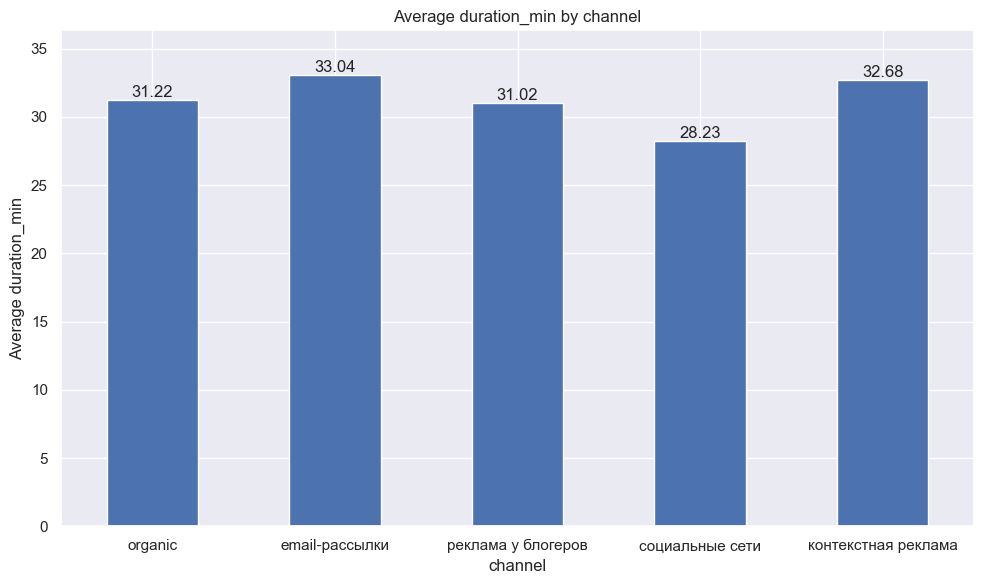

channel
organic                31.22
email-рассылки         33.04
реклама у блогеров     31.02
социальные сети        28.23
контекстная реклама    32.68
Name: duration_min, dtype: float64

In [8]:
calculate_average_metric(df, metric_col='duration_min', groupby_cols='channel', 
                         visualize=True, save=True, category_order=channel_order_by_cost)

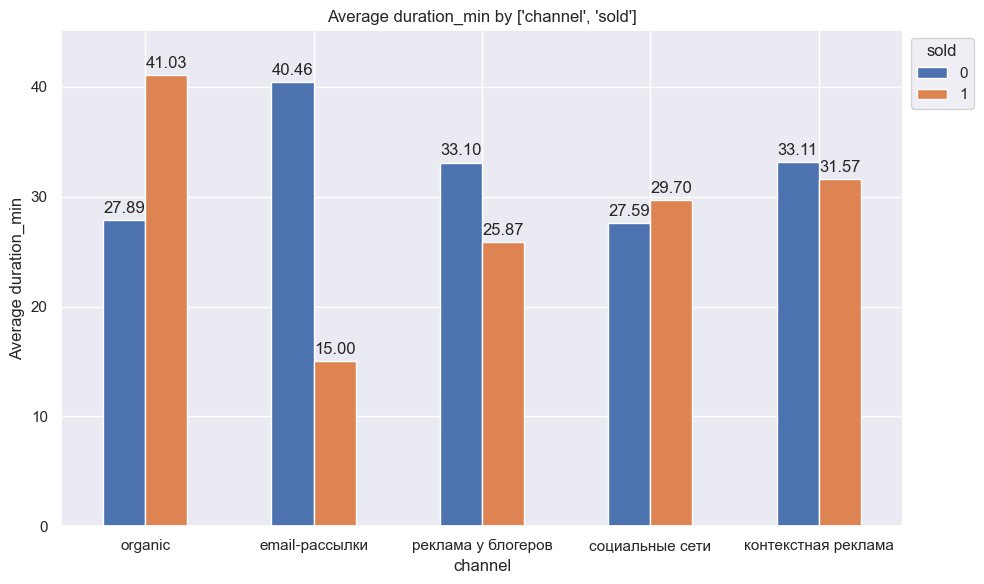

channel              sold
organic              0       27.89
                     1       41.03
email-рассылки       0       40.46
                     1       15.00
реклама у блогеров   0       33.10
                     1       25.87
социальные сети      0       27.59
                     1       29.70
контекстная реклама  0       33.11
                     1       31.57
Name: duration_min, dtype: float64

In [9]:
calculate_average_metric(df, metric_col='duration_min', groupby_cols=['channel', 'sold'], 
                         visualize=True, save=True, category_order=channel_order_by_cost)

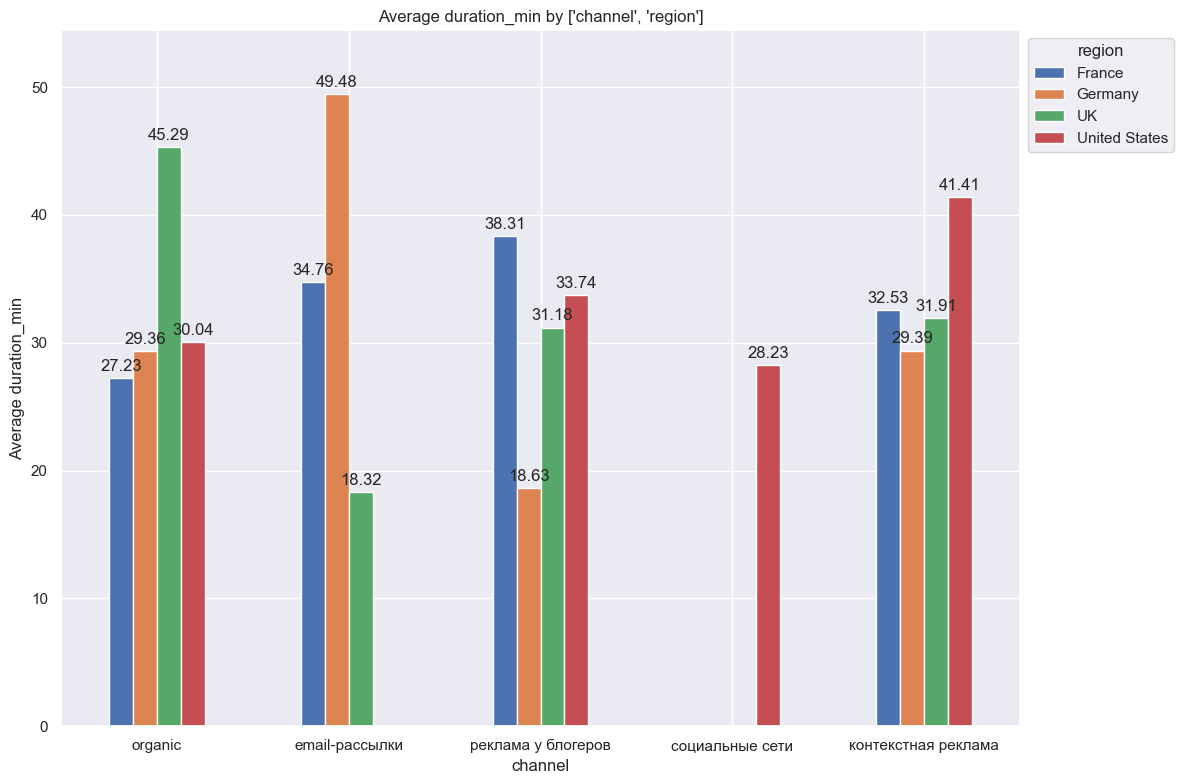

channel              region       
organic              France           27.23
                     Germany          29.36
                     UK               45.29
                     United States    30.04
email-рассылки       France           34.76
                     Germany          49.48
                     UK               18.32
реклама у блогеров   France           38.31
                     Germany          18.63
                     UK               31.18
                     United States    33.74
социальные сети      United States    28.23
контекстная реклама  France           32.53
                     Germany          29.39
                     UK               31.91
                     United States    41.41
Name: duration_min, dtype: float64

In [10]:
calculate_average_metric(df, metric_col='duration_min', groupby_cols=['channel', 'region'], 
                         visualize=True, save=True, category_order=channel_order_by_cost, fig_size=(12,8))

# Рассчитать среднюю продолжительность сессии по типу устройства

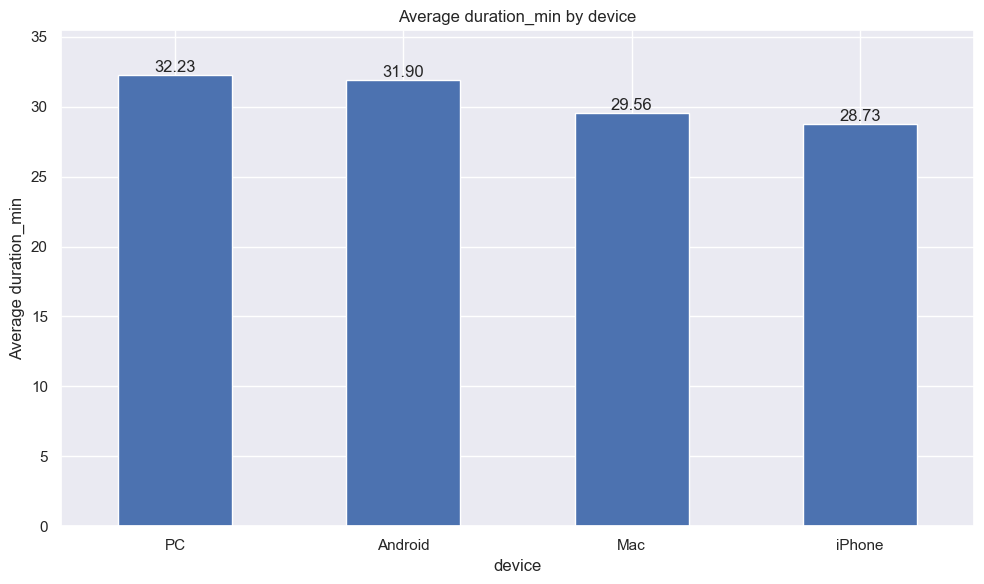

device
PC         32.23
Android    31.90
Mac        29.56
iPhone     28.73
Name: duration_min, dtype: float64

In [11]:
calculate_average_metric(df, metric_col='duration_min', groupby_cols='device', 
                         visualize=True, save=True)

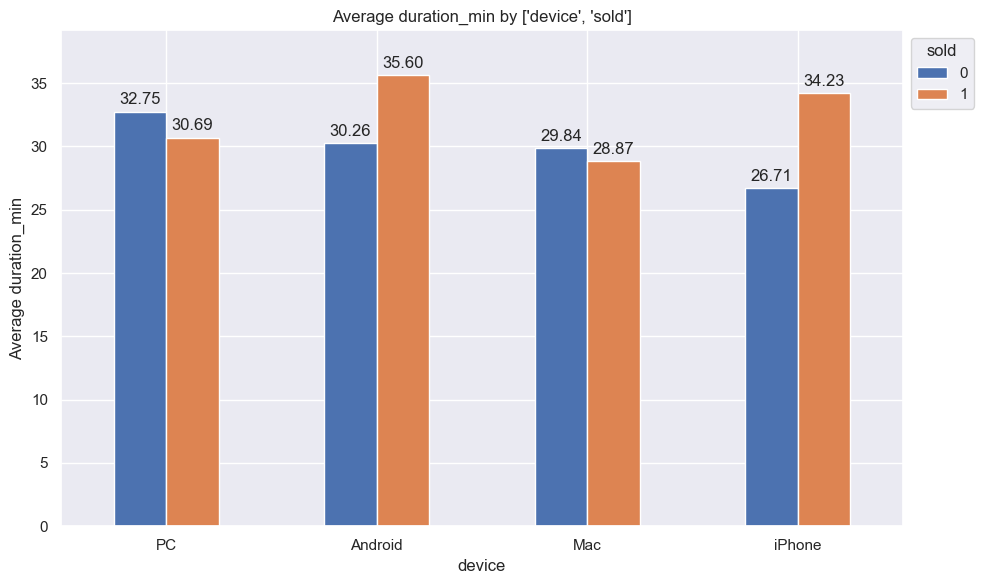

device   sold
PC       0       32.75
         1       30.69
Android  0       30.26
         1       35.60
Mac      0       29.84
         1       28.87
iPhone   0       26.71
         1       34.23
Name: duration_min, dtype: float64

In [12]:
calculate_average_metric(df, metric_col='duration_min', groupby_cols=['device', 'sold'], 
                         visualize=True, save=True)

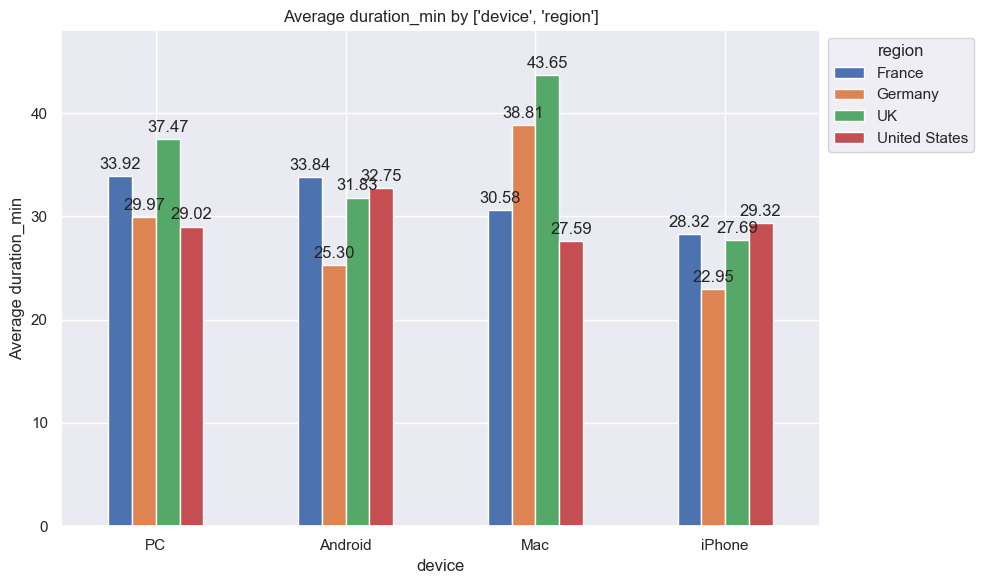

device   region       
PC       France           33.92
         Germany          29.97
         UK               37.47
         United States    29.02
Android  France           33.84
         Germany          25.30
         UK               31.83
         United States    32.75
Mac      France           30.58
         Germany          38.81
         UK               43.65
         United States    27.59
iPhone   France           28.32
         Germany          22.95
         UK               27.69
         United States    29.32
Name: duration_min, dtype: float64

In [13]:
calculate_average_metric(df, metric_col='duration_min', groupby_cols=['device', 'region'], 
                         visualize=True, save=True)

# Определить топ-3 рекламных канала по среднему чеку

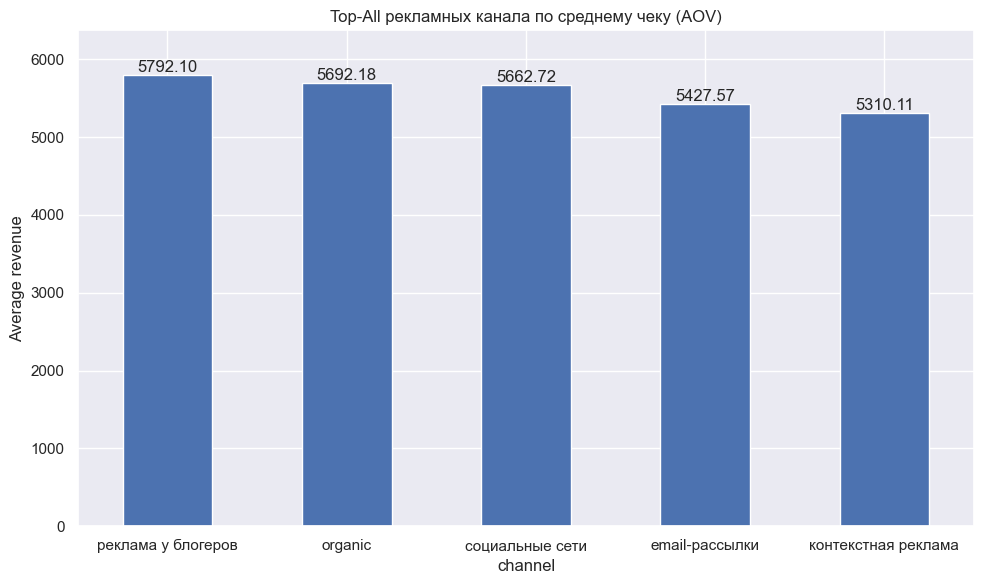

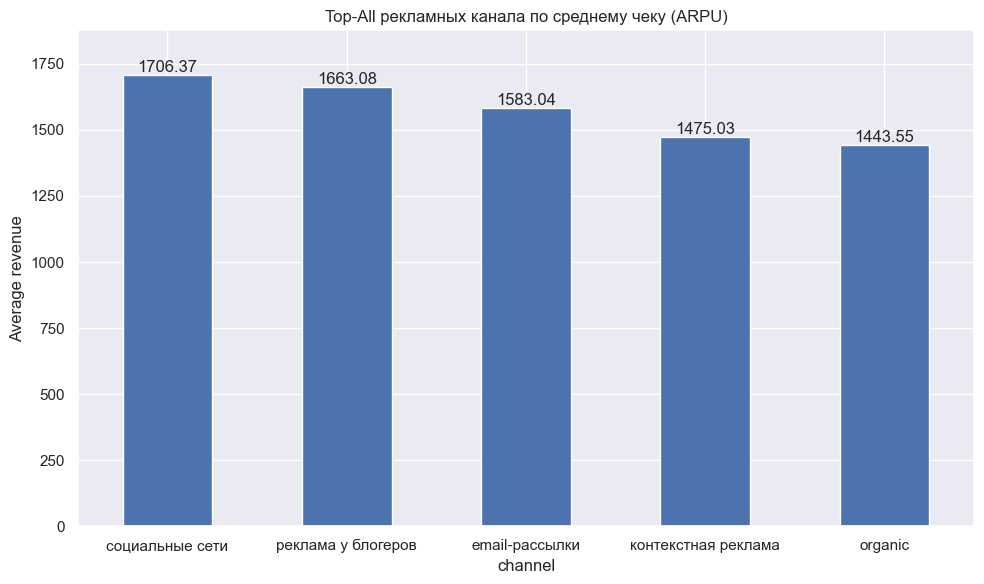

In [14]:
calculate_average_metric(df, metric_col='revenue', groupby_cols='channel', top_n=None, metric_type='aov',
                         visualize=True, save=True, title='Top-All рекламных канала по среднему чеку (AOV)')
calculate_average_metric(df, metric_col='revenue', groupby_cols='channel', top_n=None, metric_type='arpu',
                         visualize=True, save=True,  title='Top-All рекламных канала по среднему чеку (ARPU)');

# Определить топ-3 региона по среднему чеку

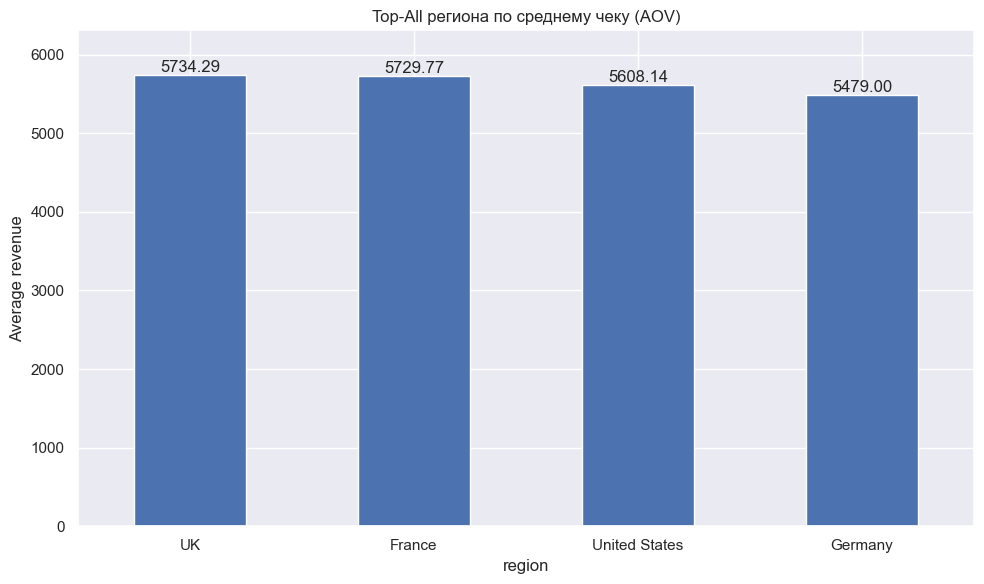

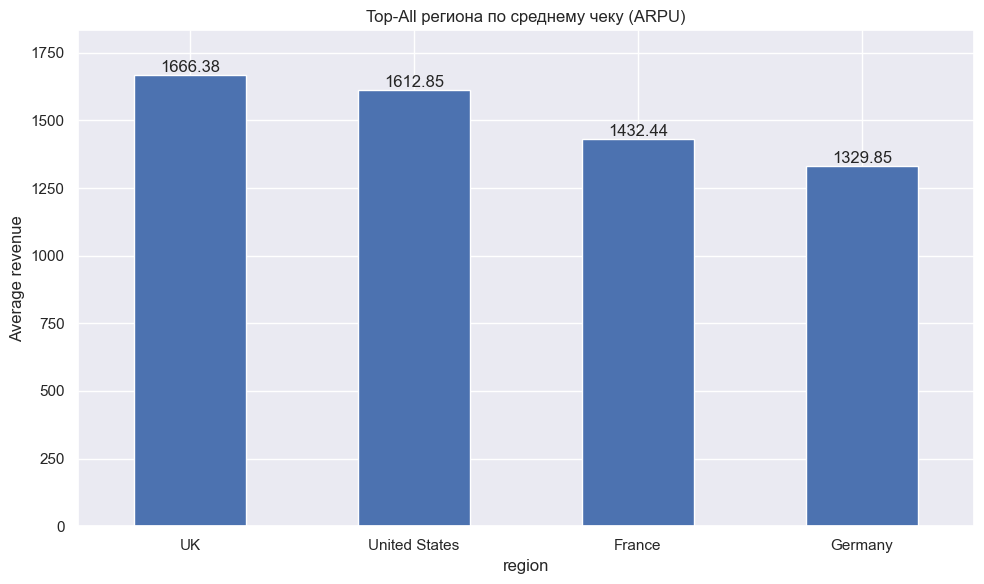

region
UK               1666.38
United States    1612.85
France           1432.44
Germany          1329.85
Name: revenue, dtype: float64

In [15]:
calculate_average_metric(df, metric_col='revenue', groupby_cols='region', top_n=None, metric_type='aov',
                         visualize=True, save=True, title='Top-All региона по среднему чеку (AOV)')
calculate_average_metric(df, metric_col='revenue', groupby_cols='region', top_n=None, metric_type='arpu',
                         visualize=True, save=True, title='Top-All региона по среднему чеку (ARPU)')

# Определить топ-3 месяца по среднему чеку с разбивкой по регионам

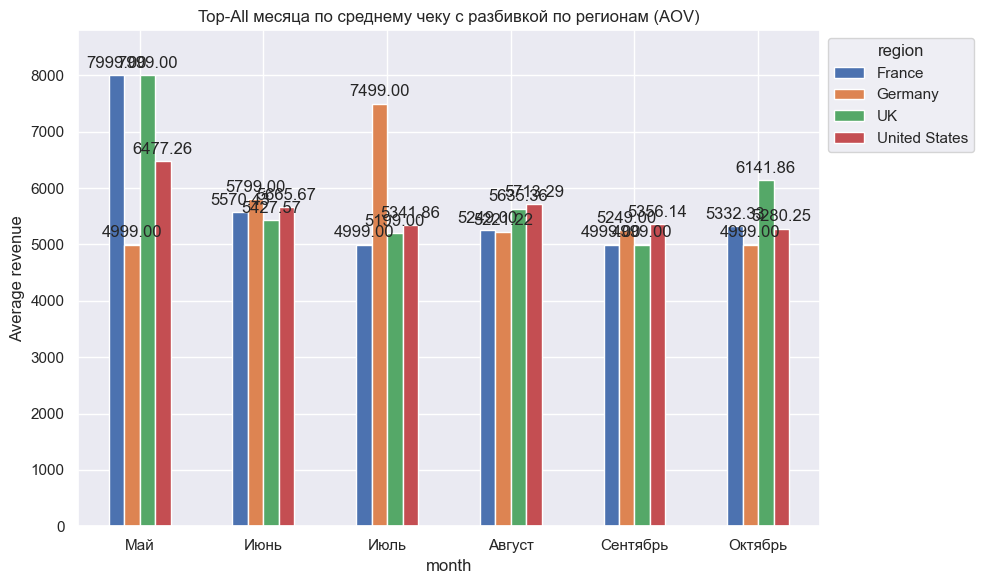

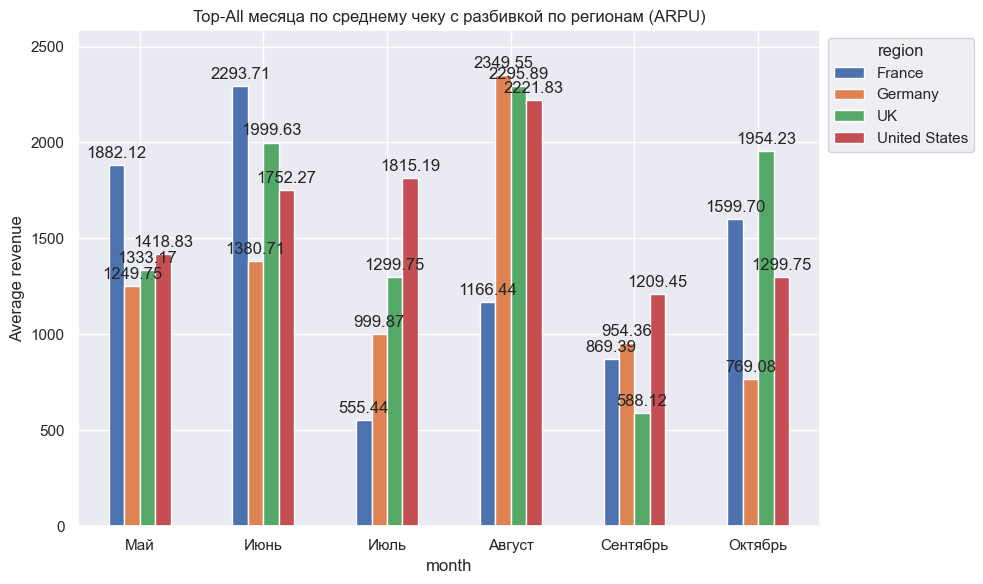

In [16]:
calculate_average_metric(df, metric_col='revenue', groupby_cols=['month', 'region'], top_n=None, metric_type='aov',
                         visualize=True, save=True, chronological=True,
                         title='Top-All месяца по среднему чеку с разбивкой по регионам (AOV)')
calculate_average_metric(df, metric_col='revenue', groupby_cols=['month', 'region'], top_n=None, metric_type='arpu',
                         visualize=True, save=True, chronological=True,
                         title='Top-All месяца по среднему чеку с разбивкой по регионам (ARPU)');

# MAU по каждому месяцу с разбивкой по рекламным каналам

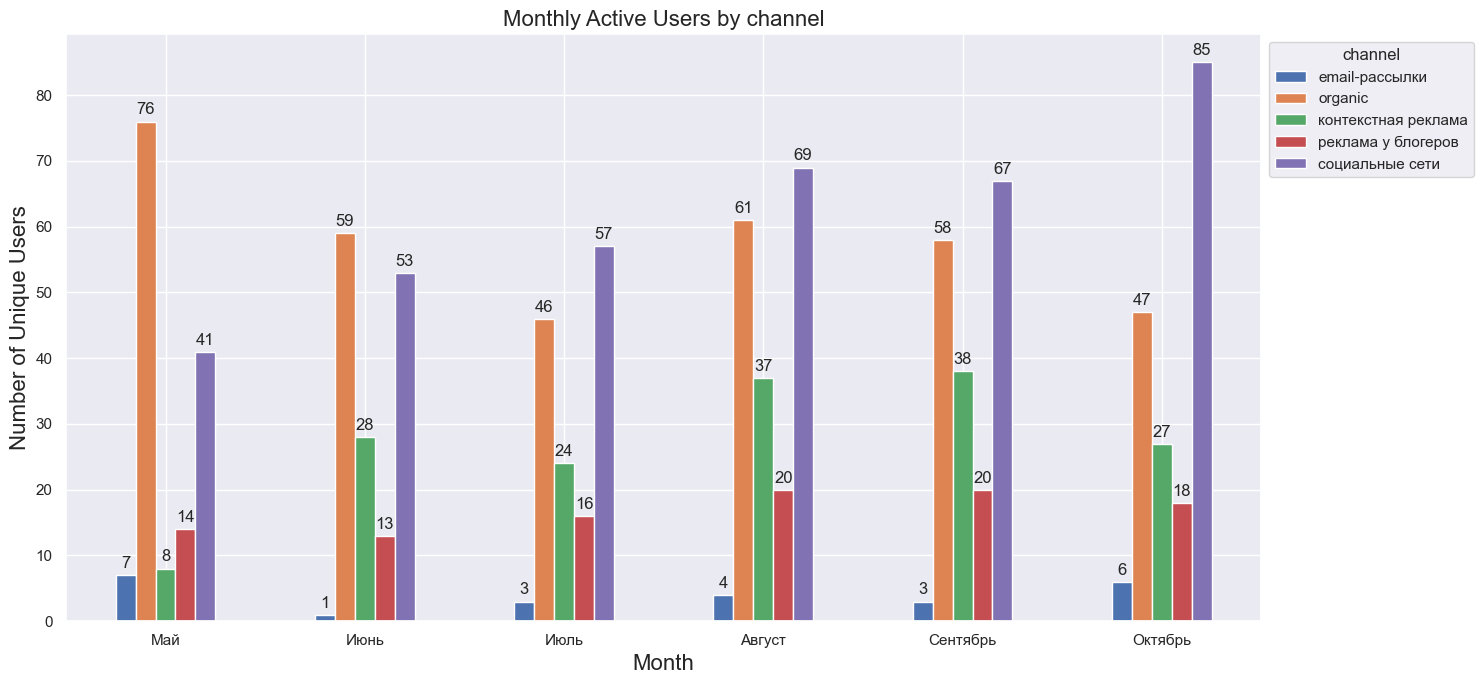

channel,email-рассылки,organic,контекстная реклама,реклама у блогеров,социальные сети
month,,,,,
Май,7,76,8,14,41
Июнь,1,59,28,13,53
Июль,3,46,24,16,57
Август,4,61,37,20,69
Сентябрь,3,58,38,20,67
Октябрь,6,47,27,18,85


In [18]:
calculate_mau(df, group_cols=['month', 'channel'], visualize=True, save=True)

# Топ-3 рекламных каналов по количеству уникальных пользователей в месяц

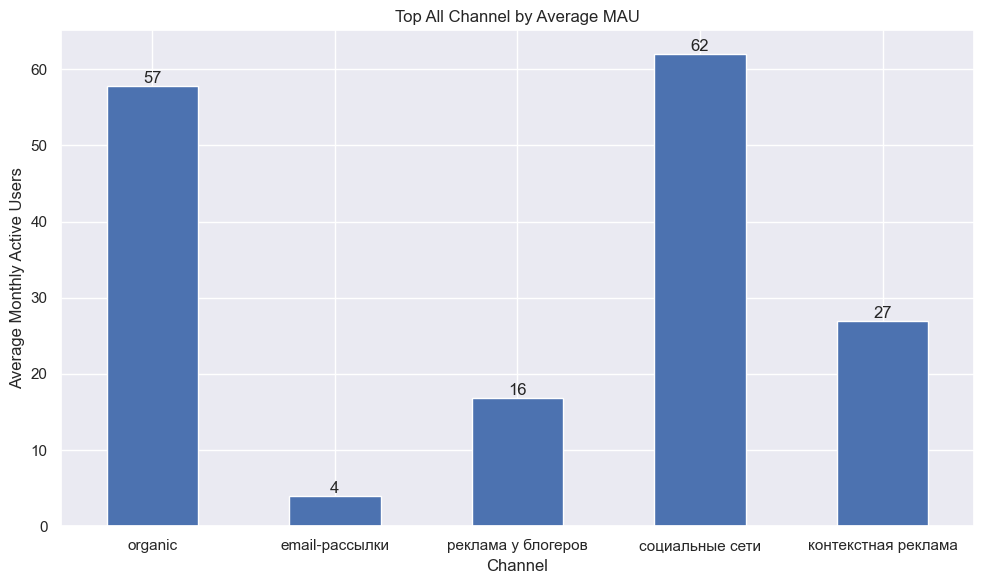

channel
organic                57.833333
email-рассылки          4.000000
реклама у блогеров     16.833333
социальные сети        62.000000
контекстная реклама    27.000000
dtype: float64

In [23]:
get_top_by_mau(df, n=None, visualize=True, save=True, category_order=channel_order_by_cost)

# Channel Table

In [56]:
def analyze_channels_performance(df, visualize=False, category_order=None):
    stats = df.groupby('channel').agg({
        'user_id': ['count', 'nunique'],
        'sold': 'sum',
        'revenue': 'sum'
    }).round()
    
    stats.columns = [
        'Total Users',
        'Unique Users',
        'Paying Users',
        'Total Revenue'
    ]
    
    print(stats)
    print(f"\nTop channel by paying users: {stats['Paying Users'].idxmax()}")
    print(f"Top channel by revenue: {stats['Total Revenue'].idxmax()}")

    return stats

def plot_channel_stats(stats, metrics=['Paying Users', 'Total Revenue'], figsize=(12, 6), 
                       category_order=None, save=False):
    if category_order is not None:
        stats = stats.reindex(category_order)
    
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize)
    
    for i, (metric, ax) in enumerate(zip(metrics, axes)):
       bars = stats[metric].plot(kind='bar', ax=ax)
       ax.set_title(f'{metric} by Channel')
       ax.set_xlabel('Channel')
       ax.set_ylabel(metric)
       ax.set_ylim(0, stats[metric].max() * 1.1)
       ax.tick_params(axis='x', rotation=45)
       
       for bar in bars.patches:
           height = bar.get_height()
           ax.text(bar.get_x() + bar.get_width()/2., height,
                  f'{int(height):,}',
                  ha='center', va='bottom')
    
    plt.tight_layout()
    
    if save:
        folder_path = './Graphs 3'
        os.makedirs(folder_path, exist_ok=True)
        filename = f"channel_stats.png"
        plt.savefig(
            fname=os.path.join(folder_path, filename),
            format='png',
            bbox_inches='tight',
            dpi=300
        )
    plt.show()

                     Total Users  Unique Users  Paying Users  Total Revenue
channel                                                                    
email-рассылки                24            23             7        37993.0
organic                      347           346            88       500912.0
контекстная реклама          162           159            45       238955.0
реклама у блогеров           101           100            29       167971.0
социальные сети              375           370           113       639887.0

Top channel by paying users: социальные сети
Top channel by revenue: социальные сети


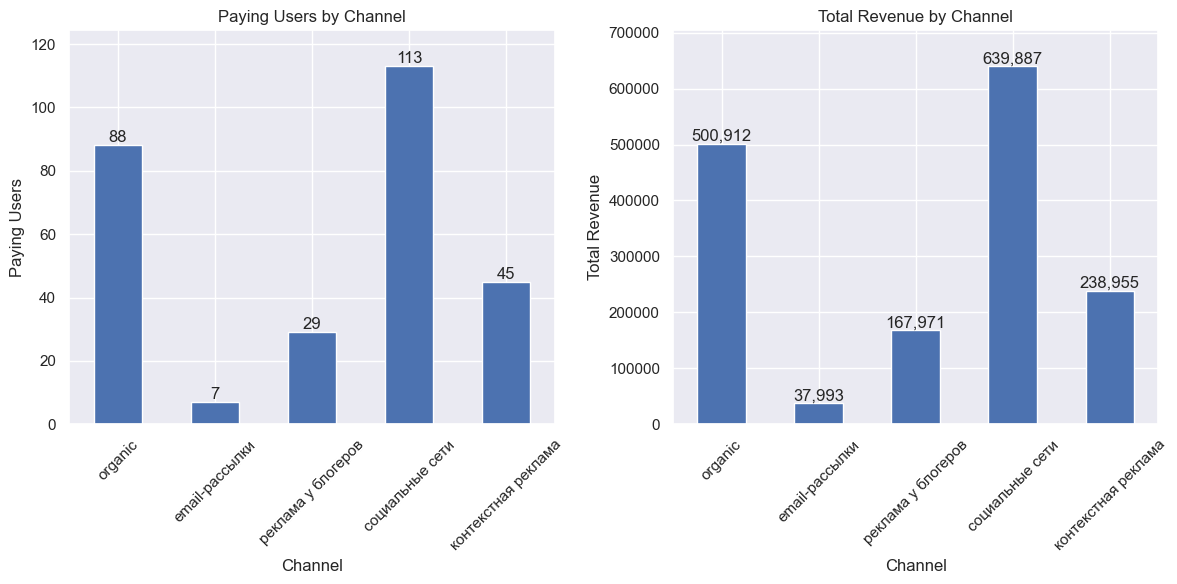

In [57]:
stats = analyze_channels_performance(df, visualize=True, category_order=channel_order_by_cost)
plot_channel_stats(stats, category_order=channel_order_by_cost, save=True)

# 